### Imports

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import keras
import pickle
import time
import tensorflow as tf
from scipy.spatial import distance
from matplotlib import pyplot as plt
import random
import shutil

### Variables

In [2]:
mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(model_complexity=0,min_detection_confidence=0.8,min_tracking_confidence=0.5)

In [3]:
model = keras.models.load_model('./models/model.h5')
scaler = pickle.load(open('./models/scaler.pkl','rb'))

#Select the number of keypoints to detect 
number_keypoints_to_detect = 6

#Select the indices of the landmarks of interest to detect from the output of the previous cell
indices_landmark_interest = [11, 12, 13, 14, 15 ,16] #0rder: left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist

### Functions

In [22]:
def mediapipe_inference(frame):
    results = pose.process(frame)
    frame_list1 = []
    start_index = 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            #If landmark visibility is not 0.5 save a NaN and this value will be replaced by the previous recorded value
            #Reference & first value is the callibraition picture 
            
            if landmark.visibility>0.5:
                if start_index in indices_landmark_interest:
                    image_hight, image_width, _ = frame.shape
                    frame = cv2.circle(frame, (int(landmark.x*image_width), int(landmark.y*image_hight)), radius=5, color = (0,255,0), thickness=-1)   
                    frame_list1.append(landmark.x*image_width)
                    frame_list1.append(landmark.y*image_hight) 
                    start_index = start_index+1
                else:
                    start_index = start_index+1
            else: 
                start_index = start_index+1
    return(frame_list1,frame)

def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

def split_2_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 2
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/2)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+2
        output.append(frame_coordinates)
    return(output)

### Load ground truth MOCAP test data

He de carregar les dades del csv MOCAP Adri01 i Xavi01 i quedar-me amb les rows corresponents als fitxers filtrats que son els que detecta bé mediapipe per despres calcular la accuracie de MediaPipe i Martinez per cadascún dels experiments

In [5]:
xavi_gt_df_2D = pd.read_csv('./data_export_1/Kinect/Xavi/Xavi01/filtered_csv/2d_TIMECODE_Xavi01.csv')
xavi_gt_df_3D = pd.read_csv('./data_export_1/Kinect/Xavi/Xavi01/filtered_csv/3d_TIMECODE_Xavi01.csv')

final_xavi_gt_df_2D = pd.DataFrame(columns=list(xavi_gt_df_2D))
final_xavi_gt_df_3D = pd.DataFrame(columns=list(xavi_gt_df_3D))

In [6]:
for filename in glob('./data_final_analysis/Xavi/*.jpg'):
    frame_timecode = (round(float(filename.split('\\')[-1].split('.jpg')[0].split('_')[-1]),3))
    
    final_xavi_gt_df_2D = final_xavi_gt_df_2D.append(xavi_gt_df_2D[xavi_gt_df_2D['timecode']==xavi_gt_df_2D[xavi_gt_df_2D['timecode']<frame_timecode]['timecode'].max()])
    final_xavi_gt_df_3D = final_xavi_gt_df_3D.append(xavi_gt_df_3D[xavi_gt_df_2D['timecode']==xavi_gt_df_3D[xavi_gt_df_3D['timecode']<frame_timecode]['timecode'].max()])

In [7]:
final_xavi_gt_df_2D = final_xavi_gt_df_2D.drop(columns=['timecode'])
final_xavi_gt_df_3D = final_xavi_gt_df_3D.drop(columns=['timecode'])

In [8]:
print(final_xavi_gt_df_2D.shape)
print(final_xavi_gt_df_3D.shape)

(497, 12)
(497, 18)


In [9]:
#Splitting in packs of 3 for a future comparisson with the predicted values by Martinez
final_xavi_gt_df_3D = pd.DataFrame(split_3_coordinates(np.array(final_xavi_gt_df_3D)))

In [46]:
df_2D = pd.DataFrame(columns=np.arange(0,number_keypoints_to_detect*2))
dfs_3D_list = []

n = 0
mp_time = []
nn_time = []

for filename in glob('./data_final_analysis/Xavi/*.jpg'):
    try:
        frame = cv2.imread(filename)
        start1 = time.time()
        #MediaPipe inference
        detected_keypoints, frame = mediapipe_inference(frame)
        end1=time.time()
        mp_time.append(end1-start1)

        df_2D = df_2D.append(pd.DataFrame(detected_keypoints).T)

        #Changing prediction order to meet the ground-truth values
        df_2D= df_2D[[2,3,6,7,10,11,0,1,4,5,8,9]]


        #NEURAL NETWORK INFERENCE

        X = np.array([list(df_2D.iloc[n])]).astype(float)
        start2 = time.time()
        X_scaled = scaler.transform(X)
        z_predicted = model.predict(X_scaled)
        end2 = time.time()
        nn_time.append(end2-start2)
        df_pred_3d = pd.DataFrame(split_3_coordinates(z_predicted))
        dfs_3D_list.append(df_pred_3d)

        n = n+1
    except:
        print(filename)

final_xavi_predicted_df_3D = pd.concat(dfs_3D_list)

In [47]:
df_2D

,2,3,6,7,10,11,0,1,4,5,8,9
0,841.702251,517.967209,694.358597,653.860738,541.965637,738.887258,1098.647575,519.187206,1167.100983,677.637041,1098.293839,779.329090
0,835.764141,517.846123,682.082691,645.006423,527.091351,730.013824,1093.557930,518.041817,1174.727097,676.321514,1096.433945,779.163265
0,838.598614,515.762401,692.789898,632.343285,539.255505,716.422427,1092.118149,516.384695,1173.979912,675.222151,1117.752686,774.481480
0,852.191792,511.609021,706.440468,624.702208,565.779247,707.310619,1096.890106,516.256174,1172.922821,680.278330,1119.998016,774.641061
0,859.562016,510.340133,722.280521,619.669268,592.539539,698.079979,1100.932961,517.632437,1172.623100,684.170001,1114.684067,781.076431
...,...,...,...,...,...,...,...,...,...,...,...,...
0,862.951183,508.842816,806.315804,660.042543,845.441093,782.904367,1092.232018,500.161858,1104.797401,638.503590,1103.322144,763.795238
0,861.045513,509.717356,804.222794,663.886771,840.422344,779.046943,1087.505951,497.774198,1105.038986,633.901691,1097.278862,763.430822
0,860.237160,513.835555,802.011738,669.521148,846.567650,782.796478,1089.793053,498.502257,1113.264427,636.759210,1099.120445,764.782333
0,863.519955,514.243712,805.327950,670.491443,849.182110,785.098908,1094.359932,499.098963,1123.343010,640.146968,1100.950928,766.295228


### Compute PCK@0.5

In [48]:
final_xavi_predicted_df_2D = df_2D.reset_index().drop(columns=['index'])

df_xavi_pred_2d = pd.DataFrame(split_2_coordinates(np.array(final_xavi_predicted_df_2D).astype(float)))
df_xavi_gt_2d = pd.DataFrame(split_2_coordinates(np.array(final_xavi_gt_df_2D).astype(float)))



In [49]:
df_xavi_pred_2d.head(5)

,0,1,2,3,4,5
0,"[841.7022514343262, 517.9672086238861]","[694.3585968017578, 653.8607382774353]","[541.9656372070312, 738.8872575759888]","[1098.647575378418, 519.187206029892]","[1167.1009826660156, 677.6370406150818]","[1098.2938385009766, 779.3290901184082]"
1,"[835.7641410827637, 517.8461229801178]","[682.082691192627, 645.006422996521]","[527.0913505554199, 730.0138235092163]","[1093.5579299926758, 518.0418169498444]","[1174.7270965576172, 676.3215136528015]","[1096.4339447021484, 779.1632652282715]"
2,"[838.5986137390137, 515.7624006271362]","[692.7898979187012, 632.3432850837708]","[539.2555046081543, 716.422426700592]","[1092.118148803711, 516.3846945762634]","[1173.9799118041992, 675.2221512794495]","[1117.752685546875, 774.4814801216125]"
3,"[852.1917915344238, 511.6090214252472]","[706.4404678344727, 624.7022080421448]","[565.7792472839355, 707.310619354248]","[1096.8901062011719, 516.2561738491058]","[1172.9228210449219, 680.2783298492432]","[1119.9980163574219, 774.6410608291626]"
4,"[859.5620155334473, 510.34013271331787]","[722.2805213928223, 619.6692681312561]","[592.5395393371582, 698.0799794197083]","[1100.932960510254, 517.6324367523193]","[1172.6231002807617, 684.1700005531311]","[1114.684066772461, 781.0764312744141]"


In [50]:
df_xavi_gt_2d.head(5)

,0,1,2,3,4,5
0,"[786.092, 539.794]","[625.248, 636.931]","[468.065, 741.585]","[1060.033, 522.632]","[1201.43, 718.999]","[1044.629, 795.628]"
1,"[793.494, 535.935]","[627.514, 636.31]","[476.31, 734.568]","[1064.2, 522.233]","[1201.554, 723.075]","[1044.539, 796.062]"
2,"[799.875, 532.641]","[631.879, 637.189]","[490.603, 725.147]","[1067.249, 521.987]","[1201.148, 725.495]","[1044.721, 796.357]"
3,"[814.062, 523.157]","[651.142, 648.232]","[561.581, 687.645]","[1072.732, 519.083]","[1195.585, 726.5]","[1044.751, 796.51]"
4,"[818.179, 521.793]","[656.598, 653.298]","[591.506, 679.364]","[1074.647, 518.127]","[1193.487, 726.787]","[1044.827, 796.463]"


In [51]:
all_distances = []

#For keypoint
for i in range(0,df_xavi_pred_2d.shape[1]):
    keypoint_distances = []
    #For row
    for j in range(0,len(df_xavi_gt_2d[i])):
        keypoint_distances.append(distance.euclidean(df_xavi_gt_2d[i][j], df_xavi_pred_2d[i][j]))
    all_distances.append(keypoint_distances)

df_ED = pd.DataFrame(all_distances).T
df_ED = df_ED.rename(columns=mapping_numbers_variables)

([<matplotlib.axis.YTick at 0x1c9796a8760>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

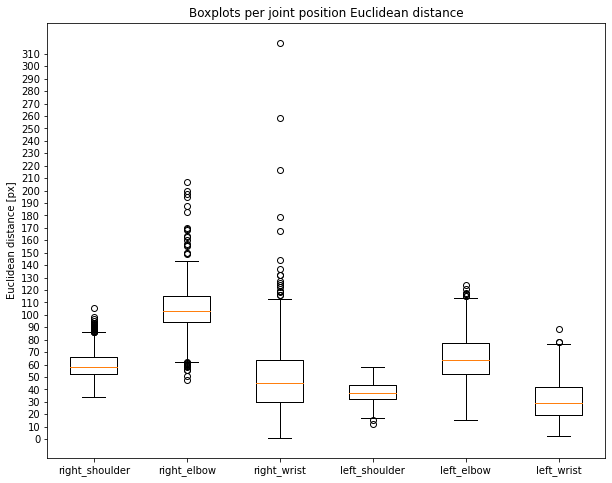

In [52]:
fig = plt.figure(figsize=(10,8))
plt.boxplot(df_ED)
plt.title('Boxplots per joint position Euclidean distance')
plt.ylabel('Euclidean distance [px]')
positions = list(mapping_numbers_variables.keys())
positions = [i+1 for i in positions]
labels = list(mapping_numbers_variables.values())
plt.xticks(positions,labels)
plt.yticks(np.arange(int(df_ED.min().min()), int(df_ED.max().max()), 10))

In [53]:
#150 pixels is the head bone link of the woman virtual character. (Head-bone link --> Des de el entrecejo hasta inicio columna)
threshold = 0.5*150 

#Se calcula PCK por cada imágen y luego se hace la media

PCK_per_image = []
for i in range(0,len(df_ED)):
    condition = []
    for di in df_ED.iloc[i]:
        condition.append(di < threshold)
    PCK_per_image.append(sum(condition)/number_keypoints_to_detect)
        
        
PCK = sum(PCK_per_image)/len(PCK_per_image)
print('The PCK@0.5 for the MediaPipe Detections is: '+'\033[1m'+str(PCK))
    

The PCK@0.5 for the MediaPipe Detections is: 0.7468142186452041


### MediaPipe output VS GroundTruth(MOCAP)

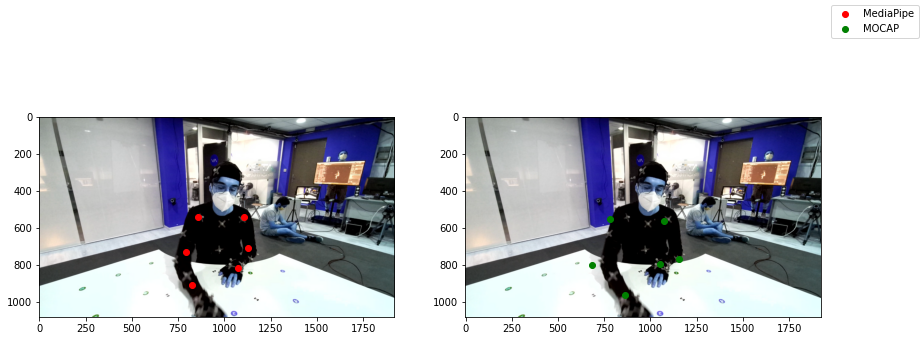

In [54]:
all_xavi_images = glob('./data_final_analysis/Xavi/*.jpg')

random_xavi_image = random.sample(all_xavi_images,1)
index = all_xavi_images.index(random_xavi_image[0])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.imshow(cv2.imread(random_xavi_image[0]))
ax1.scatter(np.array(list(df_xavi_pred_2d.iloc[index]))[:,0],np.array(list(df_xavi_pred_2d.iloc[index]))[:,1],c='red',label='MediaPipe')

ax2.imshow(cv2.imread(random_xavi_image[0]))
ax2.scatter(np.array(list(df_xavi_gt_2d.iloc[index]))[:,0],np.array(list(df_xavi_gt_2d.iloc[index]))[:,1],c='green',label='MOCAP')
fig.legend()


### Compute MPJPE

In [55]:
final_xavi_gt_df_3D.head(5)

,0,1,2,3,4,5
0,"[-0.218, 0.0, 1.206]","[-0.457, -0.132, 1.312]","[-0.562, -0.23, 1.098]","[0.118, 0.02, 1.129]","[0.29, -0.215, 1.154]","[0.088, -0.267, 1.002]"
1,"[-0.212, 0.005, 1.222]","[-0.455, -0.132, 1.313]","[-0.549, -0.221, 1.09]","[0.125, 0.021, 1.148]","[0.291, -0.22, 1.155]","[0.088, -0.267, 1.002]"
2,"[-0.206, 0.009, 1.237]","[-0.45, -0.133, 1.316]","[-0.53, -0.209, 1.083]","[0.13, 0.022, 1.164]","[0.29, -0.223, 1.156]","[0.088, -0.268, 1.002]"
3,"[-0.193, 0.022, 1.271]","[-0.425, -0.149, 1.322]","[-0.442, -0.164, 1.065]","[0.141, 0.026, 1.201]","[0.286, -0.226, 1.164]","[0.089, -0.268, 1.003]"
4,"[-0.189, 0.024, 1.28]","[-0.417, -0.156, 1.319]","[-0.408, -0.154, 1.062]","[0.144, 0.028, 1.207]","[0.284, -0.227, 1.167]","[0.089, -0.268, 1.004]"


In [56]:
final_xavi_predicted_df_3D = final_xavi_predicted_df_3D.reset_index().drop(columns=['index'])
final_xavi_predicted_df_3D.head(5)

,0,1,2,3,4,5
0,"[-0.14702001, 0.031673357, 1.2057068]","[-0.36523888, -0.151896, 1.2808466]","[-0.45406365, -0.23101635, 1.0877819]","[0.1842855, 0.033024028, 1.1914445]","[0.2774401, -0.1733334, 1.2209907]","[0.16357994, -0.252651, 1.0195562]"
1,"[-0.15932637, 0.031863406, 1.2129409]","[-0.3893656, -0.14446096, 1.2984531]","[-0.47767156, -0.22611435, 1.1012498]","[0.17562026, 0.035287514, 1.1934655]","[0.28311434, -0.17272568, 1.2207594]","[0.15641889, -0.25290963, 1.01765]"
2,"[-0.15083721, 0.035129532, 1.2144663]","[-0.37695467, -0.12991935, 1.3178713]","[-0.47350353, -0.21721439, 1.1249886]","[0.18053518, 0.037762195, 1.1952984]","[0.2914944, -0.17096612, 1.2263712]","[0.18467216, -0.2483397, 1.0207183]"
3,"[-0.131356, 0.040205345, 1.224852]","[-0.35832915, -0.1220403, 1.3262292]","[-0.44871038, -0.21144743, 1.1374254]","[0.19258744, 0.037313066, 1.2047001]","[0.29370505, -0.17516142, 1.2172505]","[0.19014478, -0.24707986, 1.0160729]"
4,"[-0.12247264, 0.04199563, 1.2320883]","[-0.34130362, -0.117290504, 1.3402348]","[-0.42834067, -0.20527068, 1.1521738]","[0.198157, 0.035137426, 1.204909]","[0.28746992, -0.17572013, 1.190027]","[0.18098606, -0.2486789, 0.9950701]"


In [57]:
#Compute the euclidean distances of each 3D predicted keypoint vs the ground truth and generate a dataframe with the results.
all_distances = []
for keypoint in list(mapping_numbers_variables.keys()):
    keypoint_distances = []
    for i in range(0,len(final_xavi_gt_df_3D[keypoint])):    
        keypoint_distances.append(distance.euclidean(final_xavi_gt_df_3D[keypoint][i], final_xavi_predicted_df_3D[keypoint][i]))
    all_distances.append(keypoint_distances)

df_PJPE = pd.DataFrame(all_distances).T
df_PJPE = df_PJPE.rename(columns=mapping_numbers_variables)
#Per joint position error dataframe euclidean distance in [mm]
(df_PJPE*1000).head(5)

,right_shoulder,right_elbow,right_wrist,left_shoulder,left_elbow,left_wrist
0,77.726740,98.926687,108.423693,91.992996,79.884944,78.907794
1,59.818226,68.372222,72.391026,69.524475,81.371634,71.586352
2,65.064980,73.134204,70.868654,61.496694,87.532048,100.411207
3,79.126849,72.039671,86.843134,52.942797,74.023922,104.109644
4,83.936054,87.631515,105.705875,54.665306,56.319700,94.416544


In [58]:
df_PJPE_mm = df_PJPE*1000
df_PJPE_mm.mean()

right_shoulder    109.327007
right_elbow       143.536255
right_wrist        68.407659
left_shoulder      84.573458
left_elbow         97.679756
left_wrist         76.615673
dtype: float64

In [59]:
df_PJPE_mm.std()

right_shoulder    20.720367
right_elbow       30.607971
right_wrist       34.080917
left_shoulder     14.620461
left_elbow        30.966611
left_wrist        27.481908
dtype: float64

In [60]:
means = []
for column in list(df_PJPE.columns):
    means.append(df_PJPE[column].mean())
    
mpjpe = sum(means)/len(df_PJPE.columns)
print('The obtained MPJPE error is: '+'\033[1m'+str(mpjpe*1000)+'mm')

The obtained MPJPE error is: 96.68996809875141mm


In [61]:
df_PJPE_mm.mean()

right_shoulder    109.327007
right_elbow       143.536255
right_wrist        68.407659
left_shoulder      84.573458
left_elbow         97.679756
left_wrist         76.615673
dtype: float64

In [62]:
df_PJPE_mm.std()

right_shoulder    20.720367
right_elbow       30.607971
right_wrist       34.080917
left_shoulder     14.620461
left_elbow        30.966611
left_wrist        27.481908
dtype: float64

Boxplot gives you a good indication of how the values in dthe data are spread out. 
IQR: BOX definied by Q1 and Q3

- Minimum: Q1-1.5*IQR
- Q1: 25th percentile --> The middle number between the smallest number and the median of the dataset
- median: 50th percentile --> The middle value of the dataset
- Q3: 75h percentile --> The middle value between the mean and the highest value
- maximum: Q3+1.5*IQR

([<matplotlib.axis.XTick at 0x1c9799136a0>,
 [Text(1, 0, 'right_shoulder'),
  Text(2, 0, 'right_elbow'),
  Text(3, 0, 'right_wrist'),
  Text(4, 0, 'left_shoulder'),
  Text(5, 0, 'left_elbow'),
  Text(6, 0, 'left_wrist')])

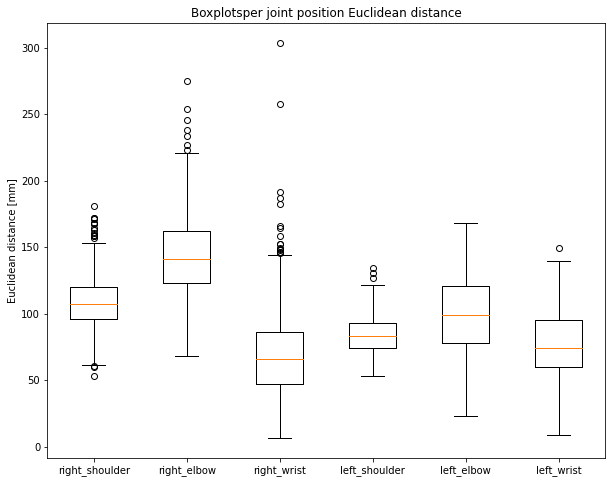

In [63]:
fig = plt.figure(figsize=(10,8))
plt.boxplot(df_PJPE*1000)
plt.title('Boxplotsper joint position Euclidean distance')
plt.ylabel('Euclidean distance [mm]')
#plt.ylim([0,80])
positions = list(mapping_numbers_variables.keys())
positions = [i+1 for i in positions]
labels = list(mapping_numbers_variables.values())
plt.xticks(positions,labels)

### Outlier analysis

In [64]:
q3_list = list(df_PJPE_mm.quantile(0.75)) #Defining third quartile per keypoint
q1_list = list(df_PJPE_mm.quantile(0.25)) #Defining first quartile per keypoint
iqr_list = list(np.array(q3_list)-np.array(q1_list)) #Defining IQR per keypoint

#Defining the threshold to be an outlier per each keypoint
maximum_values_list = np.array(q3_list) + 1.5*np.array(iqr_list) #Defining threshold to be outliers (Maximum)
max_values_dict = dict(zip(mapping_numbers_variables.values(),maximum_values_list))
max_values_dict 

{'right_shoulder': 155.2294635071006,
 'right_elbow': 221.10056956960503,
 'right_wrist': 145.29402971552196,
 'left_shoulder': 121.26495794719224,
 'left_elbow': 184.61134691592213,
 'left_wrist': 148.04345753139748}

##### NOTE: He realizado el outlier analysis a partir de los valores que superan el Maximum threshold. No obstante, podría hacerlo para los valores que superan el Q3 threshold

In [65]:
def how_many_outliers(keypoint):
    df = pd.DataFrame(columns=[keypoint])
    for key in max_values_dict.keys():
        if key == keypoint:
            outliers = df_PJPE_mm[df_PJPE_mm[keypoint] > max_values_dict.get(keypoint)]
            df = df.append(outliers)
    return(df)

In [66]:
#Euclidean distance outliers
df_outliers_ed_right_shoulder = how_many_outliers('right_shoulder')
df_outliers_ed_right_elbow =  how_many_outliers('right_elbow')
df_outliers_ed_right_wrist =  how_many_outliers('right_wrist')

df_outliers_ed_left_shoulder =  how_many_outliers('left_shoulder')
df_outliers_ed_left_elbow = how_many_outliers('left_elbow')
df_outliers_ed_left_wrist =  how_many_outliers('left_wrist')

In [67]:
#Listado de dataframes outliers
outliers = {
    'right_shoulder': df_outliers_ed_right_shoulder, 
    'right_elbow': df_outliers_ed_right_elbow, 
    'right_wrist': df_outliers_ed_right_wrist,
    'left_shoulder': df_outliers_ed_left_shoulder, 
    'left_elbow': df_outliers_ed_left_elbow,
    'left_wrist': df_outliers_ed_left_wrist
}

for element in outliers.keys():
    print('There are '+str(len(outliers[element])) +' outliers for keypoint: '+str(element))

There are 14 outliers for keypoint: right_shoulder
There are 7 outliers for keypoint: right_elbow
There are 16 outliers for keypoint: right_wrist
There are 3 outliers for keypoint: left_shoulder
There are 0 outliers for keypoint: left_elbow
There are 1 outliers for keypoint: left_wrist


##  Objective: Obtain the 3D coordinates of each outlier per keypoint and plot them to detect patterns and regions where outliers are generated

In [69]:
#I want to obtain the original ground-truth coordinates to know exactly which movement is not detected properly by RGSpipe
final_xavi_gt_df_3D = final_xavi_gt_df_3D.rename(columns=mapping_numbers_variables)

#Obtain the 3D coordinates of the outlier keypoints and the other keypoints in the same frame where the outlier is detected to ease the plotting
#GROUND-TRUTH 3D COORDINATES OF FRAMES WITH OUTLIERS
outliers_3D_coordinates_right_shoulder = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_3D_coordinates_right_elbow = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_3D_coordinates_right_wrist = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_3D_coordinates_left_shoulder = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_3D_coordinates_left_elbow = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_3D_coordinates_left_wrist = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_left_wrist.index)]

outliers_3D_dict = {
    'right_shoulder':outliers_3D_coordinates_right_shoulder,
    'right_elbow': outliers_3D_coordinates_right_elbow,
    'right_wrist': outliers_3D_coordinates_right_wrist,
    'left_shoulder': outliers_3D_coordinates_left_shoulder,
    'left_elbow': outliers_3D_coordinates_left_elbow,
    'left_wrist': outliers_3D_coordinates_left_wrist}

In [70]:
def extract_outlier_coordinates_per_keypoint(outliers_3D_coordinates_df, objective_keypoint):
    x_coords = []
    y_coords = []
    z_coords = []

    x_coords_objective_keypoint = []
    y_coords_objective_keypoint = []
    z_coords_objective_keypoint = []

    for i in range(0,len(outliers_3D_coordinates_df)):
        x_coord_frame = []
        y_coord_frame = []
        z_coord_frame = []

        x_coord_frame_objective_keypoint = []
        y_coord_frame_objective_keypoint = []
        z_coord_frame_objective_keypoint = []
        
        for keypoint in list(mapping_numbers_variables.values()):
            if keypoint == objective_keypoint:
                x_coord_frame_objective_keypoint.append(outliers_3D_coordinates_df.iloc[i][keypoint][0])
                y_coord_frame_objective_keypoint.append(outliers_3D_coordinates_df.iloc[i][keypoint][1])
                z_coord_frame_objective_keypoint.append(outliers_3D_coordinates_df.iloc[i][keypoint][2])
            else:
                x_coord_frame.append(outliers_3D_coordinates_df.iloc[i][keypoint][0])
                y_coord_frame.append(outliers_3D_coordinates_df.iloc[i][keypoint][1])
                z_coord_frame.append(outliers_3D_coordinates_df.iloc[i][keypoint][2])

        x_coords.append(x_coord_frame)
        y_coords.append(y_coord_frame)
        z_coords.append(z_coord_frame)

        x_coords_objective_keypoint.append(x_coord_frame_objective_keypoint)
        y_coords_objective_keypoint.append(y_coord_frame_objective_keypoint)
        z_coords_objective_keypoint.append(z_coord_frame_objective_keypoint)
    
    return(x_coords, y_coords, z_coords, x_coords_objective_keypoint, y_coords_objective_keypoint, z_coords_objective_keypoint)

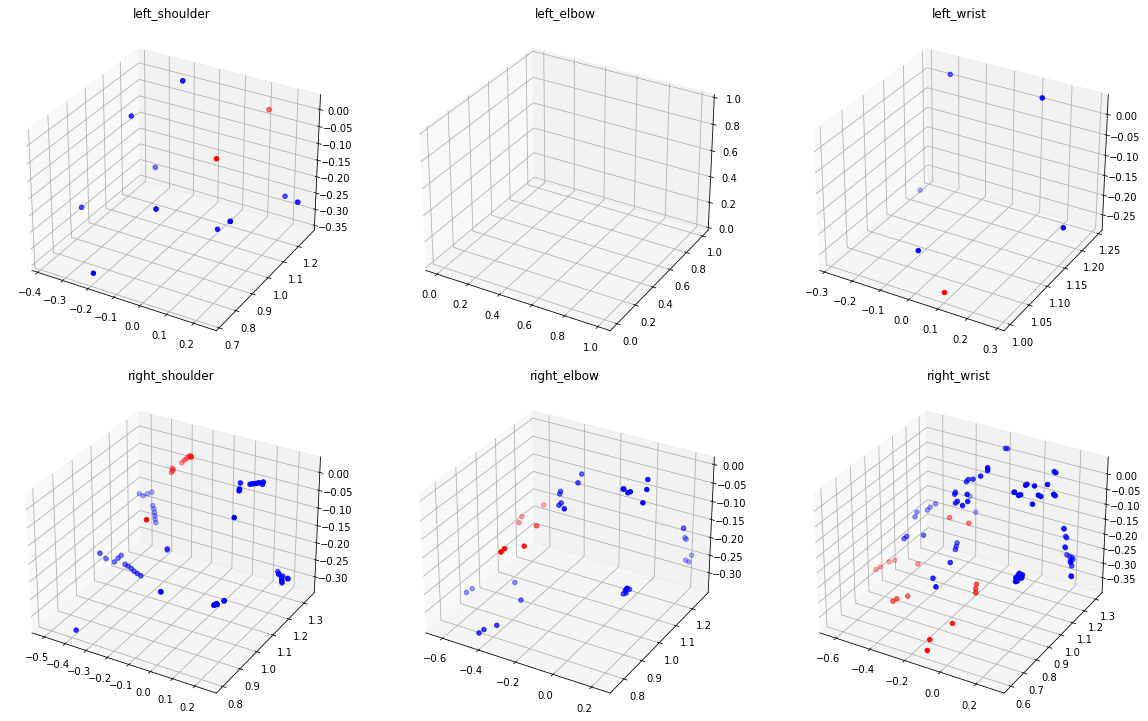

In [71]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=1)
j = 0

for i in range(0,len(outliers_3D_dict)):
    if i <= 2: 
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        x_coords_0, y_coords_0, z_coords_0, x_coords_objective_keypoint, y_coords_objective_keypoint, z_coords_objective_keypoint= extract_outlier_coordinates_per_keypoint(outliers_3D_dict[mapping_numbers_variables[i]], mapping_numbers_variables[i])
        ax.scatter(x_coords_0, z_coords_0,y_coords_0,c='blue',label='Other_Keypoints')
        ax.scatter(x_coords_objective_keypoint, z_coords_objective_keypoint,y_coords_objective_keypoint,c='red',label=mapping_numbers_variables[i])
        ax.set_title(mapping_numbers_variables[i])
    else: 
        ax = fig.add_subplot(2, 3, j+1, projection='3d')
        x_coords_0, y_coords_0, z_coords_0, x_coords_objective_keypoint, y_coords_objective_keypoint, z_coords_objective_keypoint = extract_outlier_coordinates_per_keypoint(outliers_3D_dict[mapping_numbers_variables[i]], mapping_numbers_variables[i])
        ax.scatter(x_coords_0, z_coords_0,y_coords_0,c='blue',label='Other_Keypoints')
        ax.scatter(x_coords_objective_keypoint, z_coords_objective_keypoint,y_coords_objective_keypoint,c='red',label=mapping_numbers_variables[i])
        ax.set_title(mapping_numbers_variables[i])
        j = j+1

### Save the frames in folders containing outliers for each specific keypoint 

In [72]:
path_frames_analyze = './data_final_analysis/Xavi/'
destination_outliers = './data_final_analysis/Xavi/outliers/'

In [73]:
for keypoint in list(outliers_3D_dict.keys()):
    for i in range(0,len(glob(path_frames_analyze+'*.jpg'))):
        if i in list(outliers_3D_dict[keypoint].index):
            shutil.copy(glob(path_frames_analyze+'*.jpg')[i], destination_outliers+keypoint+'/'+glob(path_frames_analyze+'*.jpg')[i].split('\\')[-1])

### Obtain insights about the detected outliers

1. Run MediaPipe Again on those frames to see if the 2D detection is performed correctly
2. Plot the 2D ground truth keypoints for those frames and the 3D too and see the differences

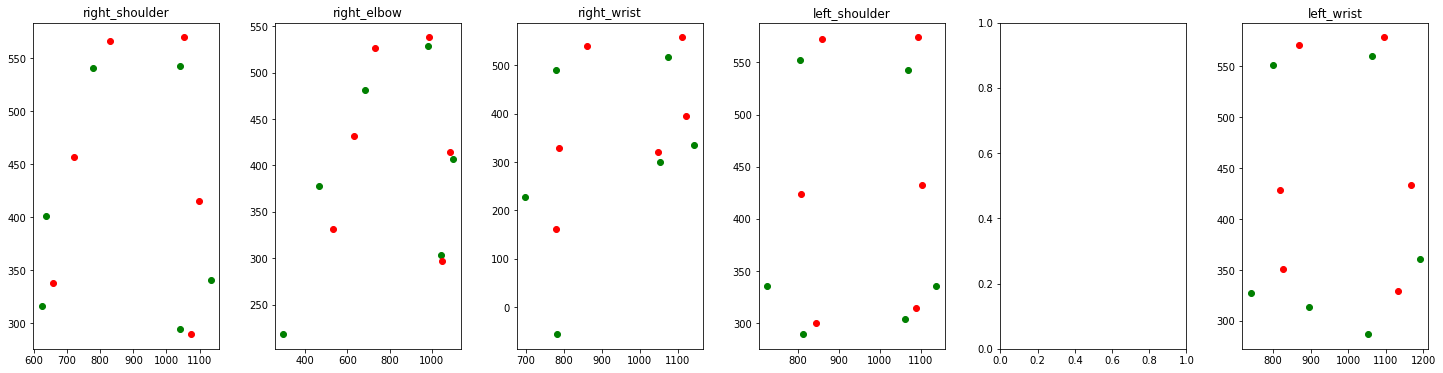

In [90]:
#Mediapipe - Predicted 2D coordinates of frames containing outliers per each keypoint
outliers_2D_mp_coordinates_right_shoulder = df_xavi_pred_2d.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_2D_mp_coordinates_right_elbow = df_xavi_pred_2d.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_2D_mp_coordinates_right_wrist = df_xavi_pred_2d.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_2D_mp_coordinates_left_shoulder = df_xavi_pred_2d.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_2D_mp_coordinates_left_elbow = df_xavi_pred_2d.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_2D_mp_coordinates_left_wrist = df_xavi_pred_2d.iloc[list(df_outliers_ed_left_wrist.index)]

#Groundtruth - Blender 2D coordinates of frames containing outliers per each keypoint
outliers_2D_gt_coordinates_right_shoulder = df_xavi_gt_2d.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_2D_gt_coordinates_right_elbow = df_xavi_gt_2d.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_2D_gt_coordinates_right_wrist = df_xavi_gt_2d.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_2D_gt_coordinates_left_shoulder = df_xavi_gt_2d.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_2D_gt_coordinates_left_elbow = df_xavi_gt_2d.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_2D_gt_coordinates_left_wrist = df_xavi_gt_2d.iloc[list(df_outliers_ed_left_wrist.index)]

#For each outlier keypoint I want to plot the 2D prediction versus the ground truth 
outliers_2D_mp_list = [
    outliers_2D_mp_coordinates_right_shoulder,
    outliers_2D_mp_coordinates_right_elbow,
    outliers_2D_mp_coordinates_right_wrist, 
    outliers_2D_mp_coordinates_left_shoulder, 
    outliers_2D_mp_coordinates_left_elbow,
    outliers_2D_mp_coordinates_left_wrist
]

outliers_2D_gt_list = [
    outliers_2D_gt_coordinates_right_shoulder, 
    outliers_2D_gt_coordinates_right_elbow, 
    outliers_2D_gt_coordinates_right_wrist,
    outliers_2D_gt_coordinates_left_shoulder,
    outliers_2D_gt_coordinates_left_elbow,
    outliers_2D_gt_coordinates_left_wrist,
]

#For each keypoint I want to select a random pair of 2D predicted and ground-truth entries that have been detected as outlier and plot them
j = 0

fig = plt.figure(figsize=(25,6))
plt.subplots_adjust(wspace = 0.3)


for i in range(0,len(outliers_2D_mp_list)):
    if len(outliers_2D_mp_list[i])>0:
        index = random.randint(0,len(outliers_2D_mp_list[i])-1) #-1 Because starts on 0 not on 1. 

        x_gt = np.array(list(outliers_2D_gt_list[i].iloc[index]))[:,0]
        y_gt = 1080-np.array(list(outliers_2D_gt_list[i].iloc[index]))[:,1]

        x_pred = np.array(list(outliers_2D_mp_list[i].iloc[index]))[:,0]
        y_pred = 1080-np.array(list(outliers_2D_mp_list[i].iloc[index]))[:,1]

        ax = fig.add_subplot(1, 6, i+1)
        ax.scatter(x_gt,y_gt,c='Green',label='Ground_truth')
        ax.scatter(x_pred,y_pred,c='red',label='Predicted')
        ax.set_title(mapping_numbers_variables[i])
    else:
        ax = fig.add_subplot(1, 6, i+1)

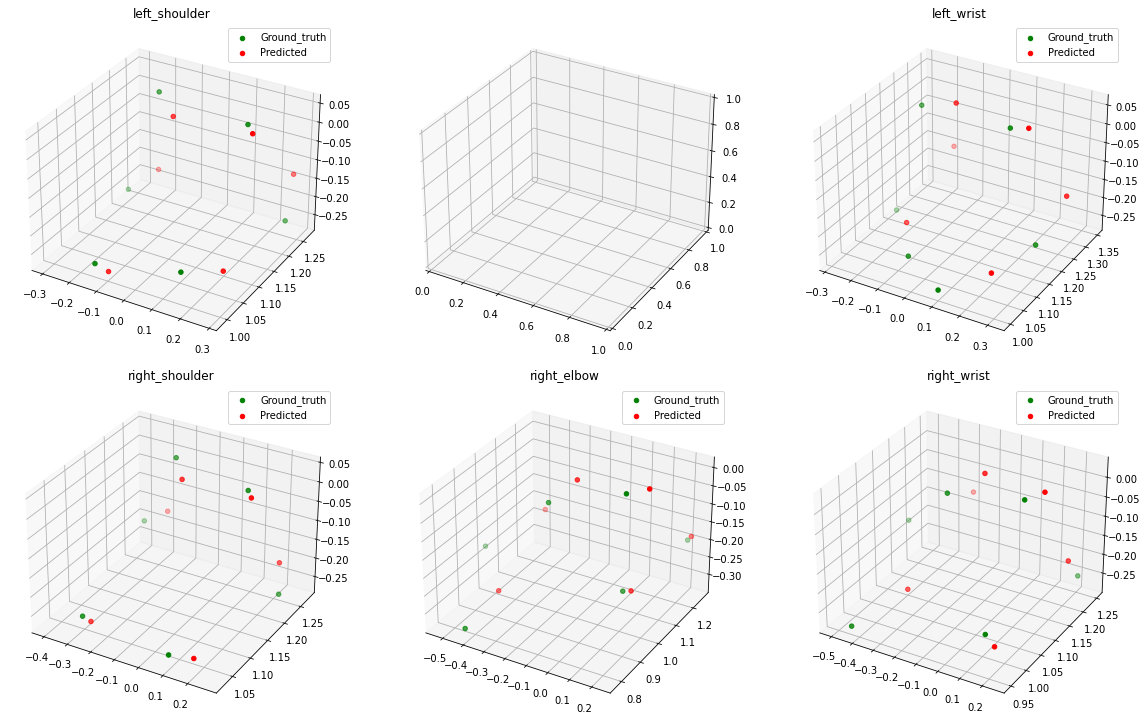

In [93]:
#MediaPipe 
outliers_3D_mp_coordinates_right_shoulder = final_xavi_predicted_df_3D.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_3D_mp_coordinates_right_elbow = final_xavi_predicted_df_3D.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_3D_mp_coordinates_right_wrist = final_xavi_predicted_df_3D.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_3D_mp_coordinates_left_shoulder = final_xavi_predicted_df_3D.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_3D_mp_coordinates_left_elbow = final_xavi_predicted_df_3D.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_3D_mp_coordinates_left_wrist = final_xavi_predicted_df_3D.iloc[list(df_outliers_ed_left_wrist.index)]


#Ground truth
outliers_3D_gt_coordinates_right_shoulder = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_right_shoulder.index)]
outliers_3D_gt_coordinates_right_elbow = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_right_elbow.index)]
outliers_3D_gt_coordinates_right_wrist = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_right_wrist.index)]

outliers_3D_gt_coordinates_left_shoulder = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_left_shoulder.index)]
outliers_3D_gt_coordinates_left_elbow = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_left_elbow.index)]
outliers_3D_gt_coordinates_left_wrist = final_xavi_gt_df_3D.iloc[list(df_outliers_ed_left_wrist.index)]

#For each outlier keypoint I want to plot the 2D prediction versus the ground truth 
outliers_3D_mp_list = [
    outliers_3D_mp_coordinates_right_shoulder,
    outliers_3D_mp_coordinates_right_elbow,
    outliers_3D_mp_coordinates_right_wrist, 
    outliers_3D_mp_coordinates_left_shoulder, 
    outliers_3D_mp_coordinates_left_elbow,
    outliers_3D_mp_coordinates_left_wrist
]

outliers_3D_gt_list = [
    outliers_3D_gt_coordinates_right_shoulder, 
    outliers_3D_gt_coordinates_right_elbow, 
    outliers_3D_gt_coordinates_right_wrist,
    outliers_3D_gt_coordinates_left_shoulder,
    outliers_3D_gt_coordinates_left_elbow,
    outliers_3D_gt_coordinates_left_wrist,
]

#For each keypoint I want to select a random pair of 3D predicted and ground-truth entries that have been detected as outlier and plot them
j = 0

fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace = 1)


for i in range(0,len(outliers_3D_mp_list)):
    if len(outliers_3D_mp_list[i]) > 0:
        index = random.randint(0,len(outliers_3D_mp_list[i])-1) #-1 Because starts on 0 not on 1. 

        x_gt = np.array(list(outliers_3D_gt_list[i].iloc[index]))[:,0]
        y_gt = np.array(list(outliers_3D_gt_list[i].iloc[index]))[:,1]
        z_gt = np.array(list(outliers_3D_gt_list[i].iloc[index]))[:,2]

        x_pred = np.array(list(outliers_3D_mp_list[i].iloc[index]))[:,0]
        y_pred = np.array(list(outliers_3D_mp_list[i].iloc[index]))[:,1]
        z_pred = np.array(list(outliers_3D_mp_list[i].iloc[index]))[:,2]

        if i <=2:
            ax = fig.add_subplot(1, 3, i+1, projection='3d')
            ax.scatter(x_gt,z_gt,y_gt,c='Green',label='Ground_truth')
            ax.scatter(x_pred,z_pred,y_pred,c='red',label='Predicted')
            ax.set_title(mapping_numbers_variables[i])
            ax.legend()
        else:
            ax = fig.add_subplot(2, 3, j+1, projection='3d')
            ax.scatter(x_gt,z_gt,y_gt,c='Green',label='Ground_truth')
            ax.scatter(x_pred,z_pred,y_pred,c='red',label='Predicted')
            ax.set_title(mapping_numbers_variables[i])
            ax.legend()
            j = j+1
    else:
        if i<=2:
            ax = fig.add_subplot(1, 3, i+1, projection='3d')
        else:
            ax = fig.add_subplot(2, 3, j+1, projection='3d')
            j = j+1
            

### Plotting 3D

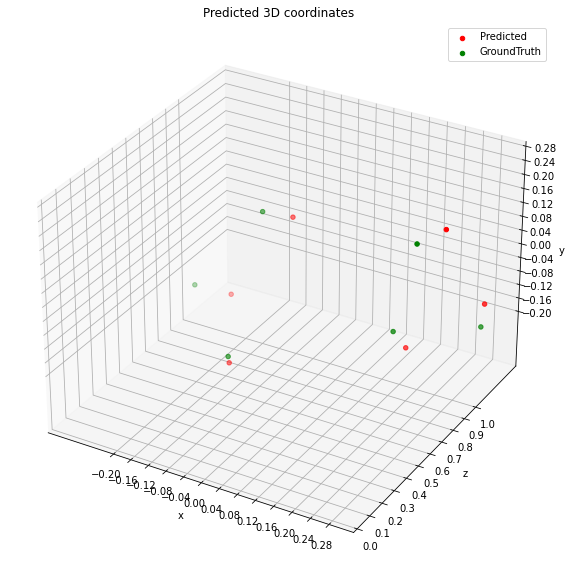

In [156]:
index = random.randint(0,len(glob('../../../MOCAP/data_final_analysis/Frames_to_analyze/Xavi/*.jpg')))

x_line = []
y_line = []
z_line = []

for keypoint in list(final_xavi_predicted_df_3D.iloc[index]):
    x_line.append(keypoint[0])
    y_line.append(keypoint[1])
    z_line.append(keypoint[2])
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


x_line2 = []
y_line2 = []
z_line2 = []

for keypoint in list(final_xavi_gt_df_3D.iloc[index]):
    x_line2.append(keypoint[0])
    y_line2.append(keypoint[1])
    z_line2.append(keypoint[2])






ax.scatter(x_line, z_line,y_line,c='red',label='Predicted')
ax.scatter(x_line2,z_line2,y_line2,c='green',label='GroundTruth')
ax.set_xticks(np.arange(-0.2,0.3,0.04))
ax.set_xlabel('x')
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_ylabel('z')
ax.set_zticks(np.arange(-0.2,0.3,0.04))
ax.set_zlabel('y')
ax.set_title('Predicted 3D coordinates')
ax.legend()